# MEA-data analysis trial with fourier transform. 

Code written by G.L. Timmerman

Contact: timmerman@ucsb.edu

In [11]:
import numpy as np
from numpy.typing import NDArray
from typing import Tuple
from MEAData import MEAData
import spike_train_tools as stt
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.rcdefaults()
plt.rc('font', family='serif')
plt.rc('mathtext', fontset='cm')

In [12]:
file_path = 'C:\\Users\\bow-lab\\Documents\\Code\\data\\240917_results\\24039_results\\000287\\sorted.npz'

mea_data = MEAData(file_path, file_type='raw', pressure=0.0, overview=True)

KEY                SHAPE              TYPE               VALUE
units              (429,)             ndarray[dict]      array([{'unit_id': 161, 'spike_train': array([  21237,   52339,   53067, ..., 5996340, 5996525, 5997794]), 'x_max': 3517.5, 'y_max': 1120.0,
locations          (1001, 2)          ndarray[ndarray]   array([[  52.5,  630. ],       [2835. , 1400. ],       [ 507.5,  892.5],       ...,       [1977.5,  507.5],       [1540. , 1732.5],       [1
fs                 ()                 ndarray            array(20000.)                                                                                                                               
spike_times        (544345,)          ndarray[int32]     array([     81,     101,     110, ..., 6000586, 6000587, 6000592])                                                                          

Each entry of the array of units is a dictionary:

unit_id            ()                 int                161                                 

In [19]:
from spike_train_tools import spike_contrast

100%|██████████| 200/200 [07:01<00:00,  2.11s/it]


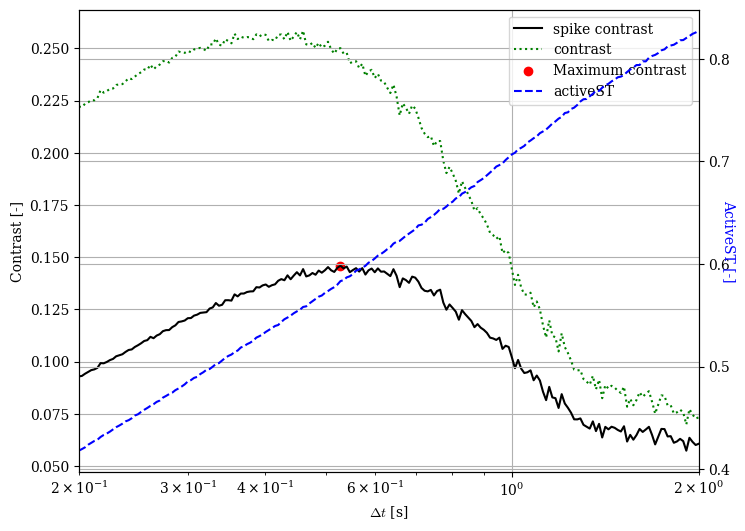

In [30]:
sc, contrast, activeST, dts = spike_contrast(mea_data.trains_binary, mea_data.sample_rate, dt_min=0.2, dt_max=2, N_points=200, plot=True)

0.5286162973948211 0.0025264438641064 0.06303367832874715


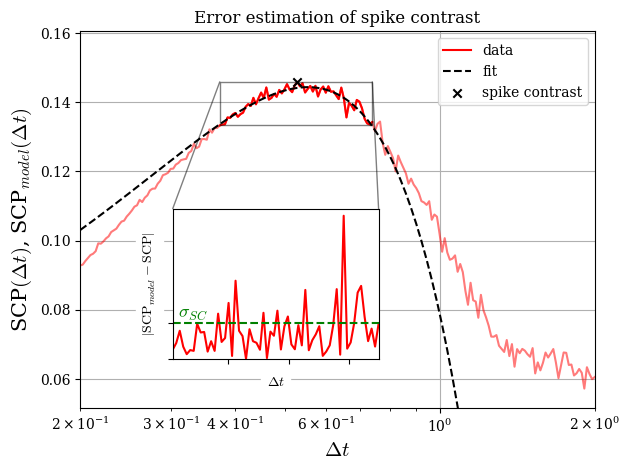

0.0013093516230776032

In [ ]:
def spike_contrast_error(sc : NDArray,
                         dts : NDArray,
                         fitrange : int = 30,
                         degree : int = 2,
                         plot : bool = False) -> Tuple[float, float]:
    
    i_max = np.argmax(sc)
    dts_sliced = dts[i_max-fitrange:i_max+fitrange]
    sc_sliced = sc[i_max-fitrange:i_max+fitrange]

    p = np.polyfit(dts_sliced, sc_sliced, degree)
    
    residue = sc_sliced - np.polyval(p, dts_sliced)
    SC_err = np.std(residue)
    dt_err = SC_err / (np.sqrt(4*p[0]*(p[2]-sc[i_max])+p[1]**2))

    if plot:
        _, ax = plt.subplots()
        ax.set_title('Error estimation of spike contrast')
        ax.plot(dts, sc, c='r', alpha=.52)
        ax.plot(dts_sliced, sc_sliced, c='r', label='data')
        ax.plot(dts, np.polyval(p, dts), c='k', linestyle='--', label='fit')
        ax.scatter(dts[i_max], sc[i_max], marker='x', c='k', zorder=100, label='spike contrast')

        ax.set_xlim(np.min(dts), np.max(dts))
        ax.set_xscale('log')
        ax.set_xlabel(r'$\Delta t$', fontsize=15)

        ax.set_ylim(0.9*np.min(sc), 1.1*np.max(sc))
        ax.set_ylabel(r'SCP$(\Delta t)$, SCP$_{model}(\Delta t)$', fontsize=15)

        ax.grid()

        axins = ax.inset_axes([0.18, 0.13, 0.4, 0.4], xlim=(np.min(dts_sliced), np.max(dts_sliced)), ylim=(np.min(sc_sliced), np.max(sc_sliced)), xticklabels=[], yticklabels=[])
        ax.indicate_inset_zoom(axins, edgecolor='k')
        axins.plot(np.log(dts_sliced), np.abs(residue), c='r', label="Inset Plot")
        axins.hlines(SC_err, np.min(np.log(dts_sliced)), np.max(np.log(dts_sliced)), color='g', linestyle='--')
        axins.set_ylabel(r'$\left|\mathrm{SCP}_{model} - \mathrm{SCP}\right|$', fontsize=10, backgroundcolor='w')
        axins.set_xlabel(r'$\Delta t$', fontsize=10, backgroundcolor='w')
        axins.set_yticks([0, SC_err], ['', ''])
        xmin, xmax = axins.set_xlim(np.min(np.log(dts_sliced)), np.max(np.log(dts_sliced)))
        axins.set_ylim(0, 1.05*np.max(np.abs(residue)))
        axins.text((xmin+xmax)/1.33, SC_err, r'$\sigma_{SC}$', c='g', verticalalignment='bottom', fontsize=13)
        axins.set_xticklabels([])

        plt.legend()
        plt.tight_layout()
        plt.savefig('C:\\Users\\bow-lab\\Documents\\Code\\figures\\error_estimate_spike_contrast.pdf')
        plt.show()

    return SC_err, dt_err


spike_contrast_error(sc, dts, plot=True)


In [6]:
avg_fir_rates = np.sum(mea_data.trains_binary, axis=1) / mea_data.T_total

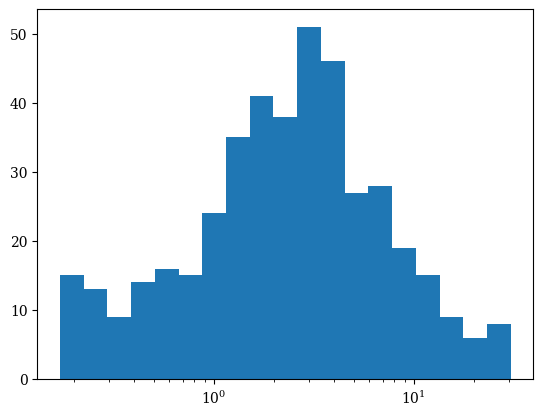

In [10]:
bins = np.geomspace(np.min(avg_fir_rates), np.max(avg_fir_rates), 20)

plt.hist(avg_fir_rates, bins=bins)
plt.xscale('log')

In [3]:
rate, time = mea_data.get_rate_total(stride=1)

#rate, time = rate[:200000], time[:200000]

sigma = np.std(rate)
mean = np.mean(rate)

In [4]:
from scipy.signal import find_peaks

peaks, props = find_peaks(rate, height=2.5*sigma, distance=5000)

out_of_burst = np.argwhere(rate < .5*sigma)[:,0]

i_lefts = []
i_rights = []

arr = np.array([-5, -3, 0.2, 0.5, 3, 1.5])

burst_durations = []

for peak in peaks:
    left = peak - out_of_burst
    left_indices = np.where(left > 0)[0]
    i_left = left_indices[np.argmin(left[left_indices])]

    right = out_of_burst - peak
    right_indices = np.where(right > 0)[0]
    i_right = right_indices[np.argmin(right[right_indices])]

    i_lefts.append(out_of_burst[i_left])
    i_rights.append(out_of_burst[i_right])
    burst_durations.append((out_of_burst[i_right]-out_of_burst[i_left])/mea_data.sample_rate)


(array([26., 47., 66., 48., 46., 32., 30., 34., 15.,  5.]),
 array([0.07185, 0.12766, 0.18347, 0.23928, 0.29509, 0.3509 , 0.40671,
        0.46252, 0.51833, 0.57414, 0.62995]),
 <BarContainer object of 10 artists>)

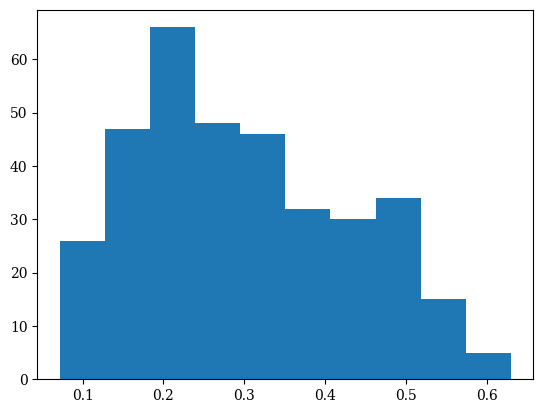

In [5]:
plt.hist(burst_durations, bins=10)

In [ ]:
_, ax1 = plt.subplots(figsize=(20, 8))

plt.title('Neuron Activity over time')

ax1.set_ylabel('Unit number [-]')

for i, row in enumerate(mea_data.trains_binary[:,:200000]):
    for j in range(len(i_lefts)):

        train_in = i_lefts[j] + np.where(row[i_lefts[j]:i_rights[j]])[0]

        ax1.scatter(train_in/mea_data.sample_rate, 
                np.full_like(train_in, mea_data.unit_numbers[i]), 
                s=.07, color='r')
        
        if j == 0:
            row_out = row[:i_lefts[0]]
            train_out = np.where(row_out)[0]
            ax1.scatter(train_out/mea_data.sample_rate,
                    np.full_like(train_out, mea_data.unit_numbers[i]),
                    s=.07, color='g')
        elif j == len(i_lefts)-1:
            row_out = row[i_rights[-1]:]
            train_out = i_rights[-1] + np.where(row_out)[0]
            ax1.scatter(train_out/mea_data.sample_rate,
                    np.full_like(train_out, mea_data.unit_numbers[i]),
                    s=.07, color='b')
        else:
            row_out = row[i_rights[j-1]:i_lefts[j]]
            train_out = i_rights[j-1] + np.where(row_out)[0]
            ax1.scatter(train_out/mea_data.sample_rate,
                    np.full_like(train_out, mea_data.unit_numbers[i]),
                    s=.07, color='k')


ax2 = ax1.twinx() 
for j in range(len(i_lefts)):
    ax2.plot(time[i_lefts[j]:i_rights[j]], rate[i_lefts[j]:i_rights[j]], c='r')
    if j == 0:
        ax2.plot(time[:i_lefts[j]], rate[:i_lefts[j]], c='g')
    elif j == len(i_lefts)-1:
        ax2.plot(time[i_rights[j]:], rate[i_rights[j]:], c='b')
    else:
        ax2.plot(time[i_rights[j-1]:i_lefts[j]], rate[i_rights[j-1]:i_lefts[j]], c='k')

ax2.set_ylabel('Firing rate [Hz]', rotation=270)
plt.xlabel('Time [s]')
plt.show()



KeyboardInterrupt: 

In [6]:
isi_in_burst = np.array([])
isi_out_burst = np.array([])

kk = 0

for i, row in enumerate(mea_data.trains_binary):#[:,:200000]):
    empty  = []
    for j in range(len(i_lefts)):

        row_in = row[i_lefts[j]:i_rights[j]]
        train_in = np.where(row_in)[0]
        isi_in = np.diff(train_in) / mea_data.sample_rate
        isi_in_burst = np.append(isi_in_burst, isi_in)
        
        if j == 0:
            row_out = row[:i_lefts[0]]
        else:
            row_out = row[i_rights[j-1]:i_lefts[j]]

        train_out = np.where(row_out)[0]
        isi_out = np.diff(train_out) / mea_data.sample_rate
        isi_out_burst = np.append(isi_out_burst, isi_out)

        if len(train_out) == 0:
            empty.append(True)
        else:
            empty.append(False)
        if len(train_out) == 0:
            empty.append(True)
        else:
            empty.append(False)

        if j == len(i_lefts)-1:
            row_out = row[i_rights[-1]:]
            train_out = np.where(row_out)[0]
            isi_out = np.diff(train_out) / mea_data.sample_rate
            isi_out_burst = np.append(isi_out_burst, isi_out)
            if len(train_out) == 0:
                empty.append(True)
            else:
                empty.append(False)
          
    kk += np.sum(~np.array(empty))-1

In [7]:
ISIs = np.array([])

for row in mea_data.trains_binary:
    isi = np.abs(np.diff(np.where(row)))[0] / mea_data.sample_rate
    ISIs = np.append(ISIs, isi)

In [8]:
print(len(isi_in_burst), len(isi_out_burst), kk, len(ISIs))
print(len(isi_in_burst)+ len(isi_out_burst)+ kk - len(ISIs))

311314 133826 80111 528597
-3346


In [9]:
bins = np.geomspace(1e-4, 100, 100)

IN, _ = np.histogram(isi_in_burst, bins=bins)
OUT, _ = np.histogram(isi_out_burst, bins=bins)
tot, _ = np.histogram(ISIs, bins=bins)

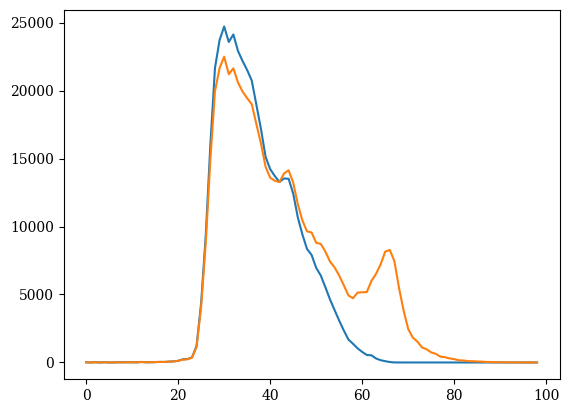

In [10]:
plt.plot(IN+OUT)
plt.plot(tot)

C:\Users\bow-lab\AppData\Local\Temp\ipykernel_26272\3690576870.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


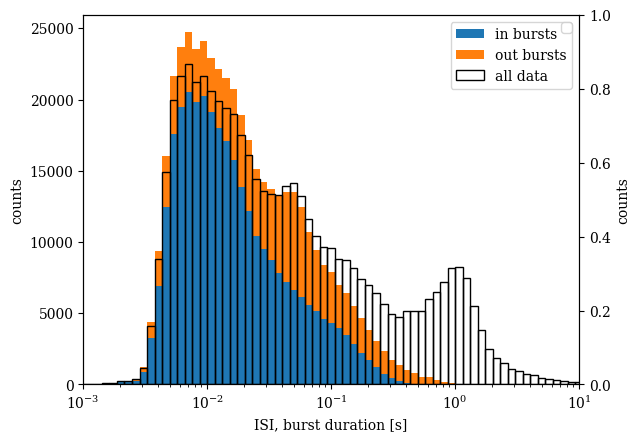

In [11]:
bins = np.geomspace(1e-4, 100, 100)

fig, ax = plt.subplots()
ax2 = ax.twinx()

#ax2.hist(burst_durations, bins=bins, label='burst duration', facecolor='g', edgecolor='k')
ax.hist([isi_in_burst, isi_out_burst], bins=bins, stacked=True, label=['in bursts', 'out bursts'])#, edgecolor='k')

#counts, bins = np.histogram(ISIs, bins=bins)

ax.hist(ISIs, bins=bins, label='all data', facecolor='none', edgecolor='k')

ax.set_xscale('log')
ax.set_xlim(1e-3, 10)
ax.set_xlabel('ISI, burst duration [s]')
ax.set_ylabel('counts')
ax2.set_ylabel('counts')
ax.legend(loc='upper right')
ax2.legend()
plt.show()

In [320]:
len(peaks)

349

In [321]:
print(len(isi_in_burst), len(isi_out_burst), (len(i_lefts)-1)*mea_data.N_units, empty, len(ISIs))
print(len(isi_in_burst)+ len(isi_out_burst)+ (len(i_lefts)-1)*mea_data.N_units- empty- len(ISIs))

311314 133249 149292 73859 528641
-8645


In [83]:
in_burst = (rate >= 2*sigma)
out_burst = (rate < 2*sigma)

(0.0, 3.0)

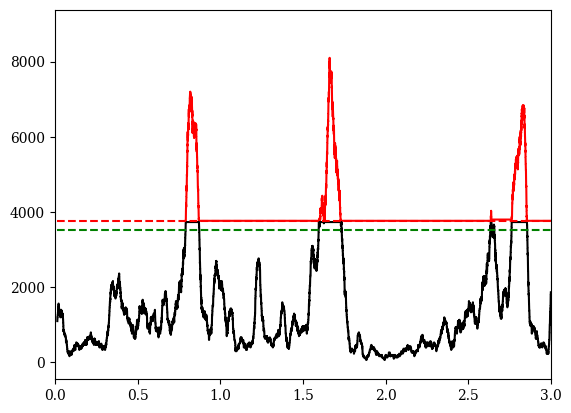

In [85]:
plt.plot(time[np.argwhere(in_burst)], rate[np.argwhere(in_burst)], c='r')
plt.plot(time[np.argwhere(out_burst)], rate[np.argwhere(out_burst)], c='k')
plt.hlines(2*sigma, time[0], time[-1], color='r', linestyle='--')
plt.hlines(2*mean, time[0], time[-1], color='g', linestyle='--')
plt.xlim(0, 3)

In [86]:
len(rate), np.shape(mea_data.trains_binary)

(6000593, (429, 6000593))

In [87]:
isi_in = np.array([])
isi_out = np.array([])

for row in mea_data.trains_binary:

    isi_in = np.append(isi_in, np.abs(np.diff(np.argwhere(row*in_burst)[:,0]))/mea_data.sample_rate)
    isi_out = np.append(isi_out, np.abs(np.diff(np.argwhere(row*out_burst)[:,0]))/mea_data.sample_rate)


In [88]:
np.argwhere(row*in_burst)

array([[  55096],
       [  55288],
       [  56189],
       [ 106486],
       [ 160834],
       [ 160956],
       [ 161864],
       [ 193578],
       [ 210358],
       [ 210545],
       [ 280972],
       [ 281220],
       [ 283309],
       [ 317018],
       [ 317281],
       [ 317413],
       [ 342951],
       [ 343098],
       [ 343230],
       [ 346217],
       [ 382443],
       [ 382547],
       [ 382653],
       [ 388273],
       [ 407730],
       [ 487765],
       [ 516363],
       [ 516545],
       [ 555488],
       [ 559553],
       [ 587703],
       [ 587784],
       [ 587867],
       [ 587972],
       [ 588059],
       [ 588768],
       [ 604576],
       [ 604659],
       [ 632054],
       [ 691432],
       [ 708104],
       [ 708422],
       [ 708628],
       [ 735070],
       [ 735207],
       [ 735303],
       [ 735476],
       [ 736284],
       [ 793362],
       [ 793473],
       [ 793575],
       [ 793651],
       [ 794932],
       [ 803419],
       [ 803517],
       [ 8

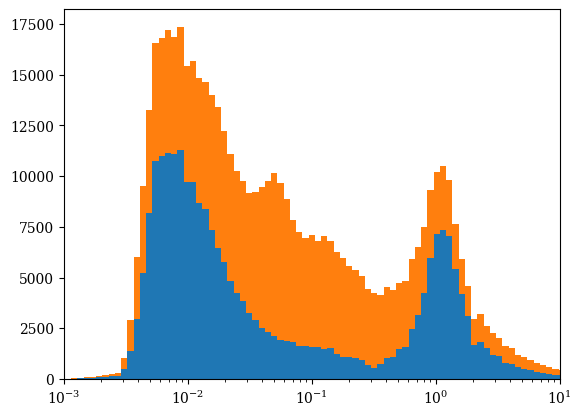

In [89]:
bins = np.geomspace(1e-4, 100, 120)

plt.hist([isi_in, isi_out], bins=bins, stacked=True)
plt.xscale('log')
plt.xlim(1e-3, 10)
plt.show()

In [41]:
import spike_train_tools as stt

sim = stt.simulate_spiketrains(mea_data.N_units, mea_data.get_rates_avg(), mea_data.T_total, mea_data.sample_rate)

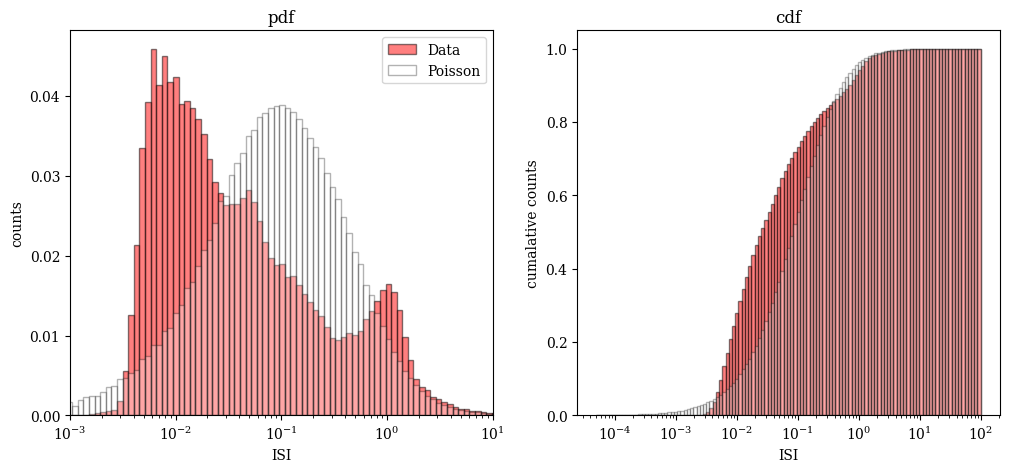

In [82]:
ISIs = np.array([])
ISIsim = np.array([])

for row in sim:
    isi = np.abs(np.diff(np.argwhere(row)[:,0]))/mea_data.sample_rate
    ISIsim = np.append(ISIsim, isi)

for row in mea_data.trains_binary:
    isi = np.abs(np.diff(np.argwhere(row)[:,0]))/mea_data.sample_rate
    ISIs = np.append(ISIs, isi)


N_bins = 120

bin_min = np.min([np.nanmin(ISIs), np.nanmin(ISIsim)])
bin_max = np.max([np.nanmax(ISIs), np.nanmax(ISIsim)])

bin_size = (bin_max - bin_min) / N_bins
bin_edges = np.geomspace(bin_min, bin_max, N_bins)
bin_sizes = np.diff(bin_edges)
bin_centers = bin_edges[1:] - bin_sizes/2

counts, _ = np.histogram(ISIs, bins=bin_edges)
counts_sim, _ = np.histogram(ISIsim, bins=bin_edges)

counts_norm = counts / len(ISIs) / np.mean(bin_sizes)
counts_sim_norm = counts_sim / len(ISIsim) / np.mean(bin_sizes)

counts_cum = np.cumsum(counts_norm) * np.mean(bin_sizes)
counts_sim_cum = np.cumsum(counts_sim_norm) * np.mean(bin_sizes)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].set_title('pdf')
axs[0].bar(bin_centers, counts_norm, width=bin_sizes, color='r', edgecolor='k', alpha=.5, label='Data')
axs[0].bar(bin_centers, counts_sim_norm, width=bin_sizes, color='white', edgecolor='k', alpha=.3, label='Poisson')
axs[0].legend()
axs[0].set_xlabel('ISI')
axs[0].set_xscale('log')
axs[0].set_ylabel('counts')
axs[0].set_xlim(1e-3, 10)

axs[1].set_title('cdf')
axs[1].bar(bin_centers, counts_cum, width=np.diff(bin_edges), color='r', edgecolor='k', alpha=.5, label='Data')
axs[1].bar(bin_centers, counts_sim_cum, width=np.diff(bin_edges), color='white', edgecolor='k', alpha=.3, label='Poisson')
axs[1].set_xlabel('ISI')
axs[1].set_xscale('log')
axs[1].set_ylabel('cumalative counts')
axs[0].set_xlim(1e-3, 10)

plt.show()

In [58]:
bin_edges

array([5.00000000e-05, 5.64810274e-05, 6.38021291e-05, 7.20721961e-05,
       8.14142336e-05, 9.19671912e-05, 1.03888029e-04, 1.17354052e-04,
       1.32565549e-04, 1.49748768e-04, 1.69159285e-04, 1.91085804e-04,
       2.15854451e-04, 2.43833623e-04, 2.75439471e-04, 3.11142086e-04,
       3.51472494e-04, 3.97030551e-04, 4.48493869e-04, 5.06627890e-04,
       5.72297274e-04, 6.46478760e-04, 7.30275692e-04, 8.24934427e-04,
       9.31862879e-04, 1.05265146e-03, 1.18909671e-03, 1.34322808e-03,
       1.51733804e-03, 1.71401623e-03, 1.93618795e-03, 2.18715770e-03,
       2.47065828e-03, 2.79090636e-03, 3.15266517e-03, 3.56131535e-03,
       4.02293500e-03, 4.54439004e-03, 5.13343637e-03, 5.79883520e-03,
       6.55048340e-03, 7.39956065e-03, 8.35869575e-03, 9.44215448e-03,
       1.06660517e-02, 1.20485912e-02, 1.36103362e-02, 1.53745154e-02,
       1.73673685e-02, 1.96185363e-02, 2.21615018e-02, 2.50340878e-02,
       2.82790199e-02, 3.19445620e-02, 3.60852336e-02, 4.07626214e-02,
      

In [170]:
rate, time = mea_data.get_rate_total(stride=1)

sigma = np.std(rate)
mean = np.mean(rate)

in_burst = (rate >= 2*sigma)
out_burst = (rate < 2*sigma)

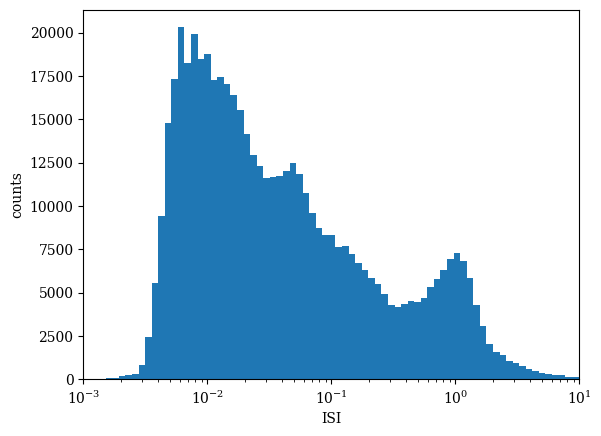

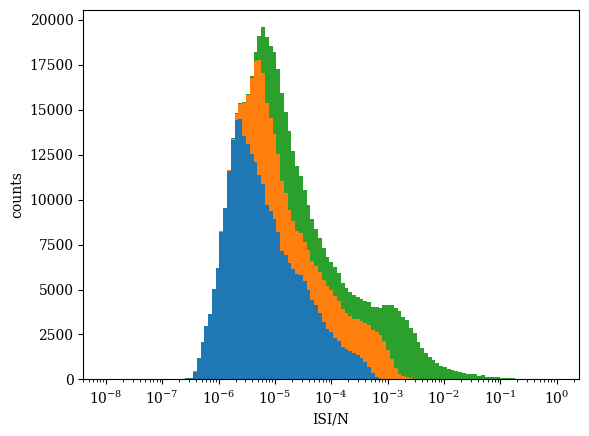

In [184]:
ISIs = np.array([])
ISI_avg = np.array([])

ISI_cats = [np.array([]),
            np.array([]),
            np.array([])]

t1 = 2000
t2 = 1000

for row in mea_data.trains_binary:
    isi = np.abs(np.diff(np.argwhere(row)[:,0]))/mea_data.sample_rate
    ISIs = np.append(ISIs, isi)
    ISI_avg = np.append(ISI_avg, np.mean(isi))
    if np.sum(row) > t1:
        ISI_cats[0] = np.append(ISI_cats[0], isi/np.sum(row))
    elif np.sum(row) < t2:
        ISI_cats[2] = np.append(ISI_cats[2], isi/np.sum(row))
    else:
        ISI_cats[1] = np.append(ISI_cats[1], isi/np.sum(row))

bins = np.geomspace(np.min(ISIs), np.max(ISIs), 120)
plt.hist(ISIs, bins=bins)
plt.xscale('log')
plt.xlim(1e-3, 10)
plt.xlabel('ISI')
plt.ylabel('counts')
plt.show()

plt.hist(ISI_cats, bins=np.geomspace(1e-8, 1, 120), stacked=True)
plt.xscale('log')
#plt.xlim(1e-3, 10)
plt.xlabel('ISI/N')
plt.ylabel('counts')
plt.show()



In [171]:
len(ISIs), len(isi_in) + len(isi_out) + len(bounds)*mea_data.N_units

(0, 1254825)